<a href="https://colab.research.google.com/github/abbasmammadov/Facial-Expression-Recognition/blob/main/Error_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mount your drive first - you can do it once
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing necessary modules
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision import models
import matplotlib.pyplot as plt

In [ ]:
from collections import OrderedDict
model_path = '/content/drive/MyDrive/ML Project Folder/Models'
# best_model_path = os.path.join(model_path, 'best-resnet.h5')
model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(OrderedDict([
    ('dropout1', nn.Dropout(p=0.5)), 
    ('fc1', nn.Linear(2048, 4096)), 
    ('relu1', nn.ReLU()), 
    ('dropout2', nn.Dropout(p=0.5)), 
    ('fc2', nn.Linear(4096, 1024)), 
    ('relu2', nn.ReLU()), 
    ('dropout3', nn.Dropout(p=0.5)), 
    ('fc4', nn.Linear(1024, 7)), 
    ('softmax', nn.Softmax(dim=1))
]))
# model.load_state_dict(torch.load(best_model_path))
model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#load the dataset, and get the data augmentation ready 
# in this case the data augmentation is only converting it to a normalized tensor
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
test_augs = T.ToTensor()

In [ ]:
data_path = '/content/drive/MyDrive/ML Project Folder/project/datasets/fer2013'
# since we want to evaluate our model in our test dataset, we wll only load our test dataset
test_path = os.path.join(data_path, 'test')

# perform the data augmentation, and store the new dataset
testset = ImageFolder(test_path, transform=test_augs)

print(f"Total no. of examples in testset : {len(testset)}")

##let's load our test dataset in a format suitable to pytorch
testloader = DataLoader(testset)

Total no. of examples in testset : 3589


In [ ]:
#the label encoding used in our CSV file -> encoding which maps to emotion 
em_dict = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}
num_classes = 7

# initialize the test tensors
true_labels = torch.zeros((len(testloader)), 1)
predictions = torch.zeros((len(testloader)), 1)

In [ ]:
#get the true outputs, and the probability of each classes
with torch.no_grad():
    for i, (image, label) in enumerate(testloader):
      true_labels[i] = label
      predictions[i] = model(image).argmax(1)

In [ ]:
#the accuracy of the model on the test result
acc = float((predictions == true_labels).sum() / len(testloader))
print('the accuracy on the test loader is: ', round(acc, 5))

the accuracy on the test loader is:  0.15297


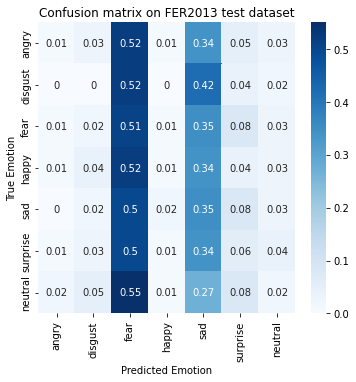

In [ ]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

#build a heatmap which helps us to visualize the confusion matrix
conf_mat_colored = pd.DataFrame(confusion_matrix(true_labels, predictions, normalize='true').round(2), index=em_dict.values(), columns=em_dict.values())

#now plot it
plt.figure(figsize=(5,5))
heatmap(conf_mat_colored, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion matrix on FER2013 test dataset')
plt.ylabel('True Emotion')
plt.xlabel('Predicted Emotion')
plt.show()

your emotion: sad


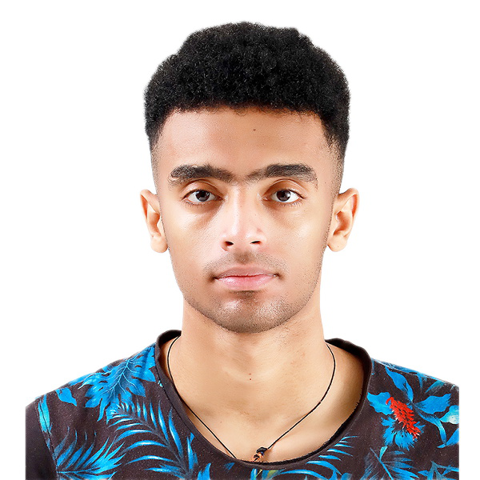

In [ ]:
#try our model with your own image :))
image_path = '/content/trial_image.jpg' # replace it with your image directory
my_image = Image.open(image_path) 
transforms= T.Compose([T.Resize((48, 48)), T.ToTensor()]) # call the transformations to convert the image to normalized tensors
single_loader = transforms(my_image)
pred_label_index = int(model(single_loader.unsqueeze(0)).argmax(1))
print('your emotion:', em_dict[pred_label_index])
# my_image